### Import Libraries

In [1]:
import datetime, os, math, copy
import random
import pickle

from random import shuffle
from tqdm import tqdm
from statistics import mode

import numpy as np

# scikit-learn
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances, cosine_distances
from sklearn.cluster import KMeans
from sklearn.metrics import roc_curve, auc, davies_bouldin_score, silhouette_score # cluster metrices
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix # agent metrices
from sklearn.svm import SVC
# from sklearn.model_selection import GridSearchCV

# Pandas
import pandas as pd

### Select Base model to be used for image features, select distance type and define dataset size

In [2]:
selected_model = 1 #int(input("Enter the number for: \n 1) VGG16 \n 2) Resnet101  \n 3) Densenet169 "))

distance_type = 3 # int(input("Enter the number for: \n 1) Euclidean  \n 2) Manhattan \n 3) Cosine"))

DATASET_SIZE = 1 # (max: 1, min: 0.2)

### Open extracted feature in pickle file

In [3]:
filepath = "../../pickle_files/al/ct_scan/pneumonia_"
if selected_model == 1:
  filename = "ct_scan_pca_5000_vgg16.pickle"
elif selected_model == 2:
  filename = "ct_scan_pca_5000_resnet101.pickle"
elif selected_model == 3:
  filename = "ct_scan_pca_5000_densenet169.pickle"

file = filepath + filename
with open(file, 'rb') as handle:
  all_ft_dataset = pickle.load(handle)

### Sample the data and shuffle

In [4]:
# suffle the data
random.seed(42)
shuffle(all_ft_dataset)

print("Total Dataset: {}".format(len(all_ft_dataset)))
print("Sample feature dataset Covid: {}".format(all_ft_dataset[0]))
print("Sample feature dataset Non-Covid: {}".format(all_ft_dataset[1200]))

# shrink for minimize training time
original_data_size = len(all_ft_dataset)
new_data_size = int(original_data_size * DATASET_SIZE)
ft_dataset = all_ft_dataset[:new_data_size]

print("Selected Dataset: {}".format(len(ft_dataset)))
print("Number of features in a image: {}".format(ft_dataset[0]['image'].shape[0]))

Total Dataset: 5000
Sample feature dataset Covid: {'id': 1383, 'filepath': '../../dataset/ctscan/3A_images_resized/all\\Normal\\Normal_1679_838_0035.png', 'image': array([-1.7125643e+01, -3.7122512e-01,  1.0066563e+01, ...,
        1.0989258e-02, -3.8238191e-03,  8.0061131e-05], dtype=float32), 'label': 0}
Sample feature dataset Non-Covid: {'id': 3811, 'filepath': '../../dataset/ctscan/3A_images_resized/all\\Pneumonia\\CP_1195_3413_0176.png', 'image': array([ 6.2833481e+00, -7.2029126e-01, -9.3829775e+00, ...,
       -8.7235412e-03, -1.0556433e-03,  8.0232669e-05], dtype=float32), 'label': 1}
Selected Dataset: 5000
Number of features in a image: 5000


### Define a custom class inherited from KMeans

In [5]:
class MyKMeans(KMeans):
  def __init__(self, n_clusters, random_state=0, n_init="auto"):
    KMeans.__init__(self, n_clusters=n_clusters, random_state=random_state, n_init=n_init)
    self.cluster_members_ = []

  def __update_members(self, new_members):
    self.cluster_members_ = new_members

  def __update_centers(self, new_cluster_centers):
    self.cluster_centers_ = new_cluster_centers

  def __update_labels(self, new_labels):
    self.labels_ = new_labels

  def merge_subclusters(self, subclusters):
    members = []
    for subcluster in subclusters:
      members.extend(subcluster)
    return members

  def update(self, centers_neg, centers_pos, clusters_neg, clusters_pos):
    c_centers_neg = np.mean(centers_neg, axis=0, dtype=np.float64)
    c_centers_pos = np.mean(centers_pos, axis=0, dtype=np.float64)

    new_centers = np.array([c_centers_neg, c_centers_pos])
    self.__update_centers(new_centers)

    c_members_neg = self.merge_subclusters(clusters_neg)
    c_members_pos = self.merge_subclusters(clusters_pos)

    new_members = [c_members_neg, c_members_pos]
    self.__update_members(new_members)

    new_labels = self.predict(c_members_neg + c_members_pos)
    model_cluster.__update_labels(new_labels)


### Defina a class for human expert

In [6]:
class HumanExpert():
  def __init__(self, labeled_data):
    self.labeled_data = labeled_data

  def policy(self, instance):
    query = next(data for data in self.labeled_data if data["id"] == instance)
    return [query['label']]

### Define a class for Agent

In [7]:
class Agent():
  def __init__(self):
    self.clf = self.classifier()
    self.reward = 0
    self.avg_reward = 0
    self.reward_list = []

  def classifier(self):
    # param_grid = {'C': [0.1,1,10,100], 'gamma': [0.0001,0.001,0.1,1], 'kernel': ['rbf','linear']}
    clf = SVC(kernel="linear")
    # clf = GridSearchCV(clf, param_grid)
    return clf

  def imitate_human(self, demo_data):
    shuffle(demo_data)
    X_train, y_train = [x for (x, y) in demo_data], [y for (x, y) in demo_data]
    self.clf.fit(X_train, y_train)

  def policy(self, states):
    actions = self.clf.predict(states)
    return actions

  def update_reward(self, pred, gt, n_obs):
    if pred == gt:
      self.reward += 1
      self.avg_reward = round(self.reward/n_obs, 3)

  def update_reward_list(self):
    self.reward_list.append(self.avg_reward)

  def reset_reward(self):
    self.reward = self.avg_reward = 0


### Define a function to calculate the classification metrices

In [8]:
def classification_metrices(id_gt, id_pred):
  TP, FP, FN, TN = 0, 0, 0, 0

  # TP --> when correctly classified covid
  for tp in id_pred[1]:
    if tp in id_gt[1]:
      TP += 1

  # TN --> when correctly classified healthy (non-covid)
  for tn in id_pred[0]:
    if tn in id_gt[0]:
      TN += 1

  # FP --> when incorrectly classified healthy (Classified healthy as covid)
  for fp in id_pred[1]:
    if fp in id_gt[0]:
      FP += 1

  # FN --> when missed covid classification (Covid cases missed)
  for fn in id_pred[0]:
    if fn in id_gt[1]:
      FN += 1

  accuracy = round((TP + TN) / (TP + TN + FP + FN), 3)
  if (TN + FP) > 0:
    specificity = round(TN / (TN + FP), 3)
  else:
    specificity = 0 # Infinity

  if (TP + FN) > 0:
    sensitivity = round((TP) / (TP + FN), 3)
  else:
    sensitivity = 0 # Infinity

  # f1_score = (2*precision*recall)/(precision + recall)

  # print("TP: {}  FP: {}".format(TP, FP))
  # print("FN: {}  TN: {}".format(FN, TN))

  return accuracy, specificity, sensitivity, TP, TN, FP, FN

### Define a function to calculate ROC AUC Curve

In [9]:
def roc_auc_curve(label_gt, label_pred):
  # contains (id, labels) tuple of binary class
  gt_labels = sorted(label_gt[0] + label_gt[1])

  # contains (id, labels) tuple of binary class --> sorted to match each element in gt_labels and pred_labels
  pred_labels = sorted(label_pred[0] + label_pred[1])
  y_test = [y for (x,y) in gt_labels] # Get only the labels
  y_scores = [y for (x,y) in pred_labels]
  fpr, tpr, threshold = roc_curve(y_test, y_scores)
  roc_auc = round(auc(fpr, tpr), 3)
  return roc_auc, fpr, tpr

### Define a function to calculate Cluster metrices

In [10]:
def cluster_metrices(neg_features, pos_features):
  print("Calculating Dunn's index...")
  dunn_index, davies_bouldin_index, silhouette__score = "NA", "NA", "NA"
  if len(neg_features) > 0 and len(pos_features) > 0:
    intra_dist1 = euclidean_distances(neg_features).max()
    intra_dist2 = euclidean_distances(pos_features).max()
    inter_dist = euclidean_distances(neg_features, pos_features).min()

    if intra_dist1 > intra_dist2:
      max_intra_dist= intra_dist1
    else:
      max_intra_dist = intra_dist2

    dunn_index = round(inter_dist / max_intra_dist, 3)

  print("dunn_index: ", dunn_index)

  # Davies Bouldin and Silhouette score from sklearn library.
  if len(neg_features) > 0 and len(pos_features) > 0:
    feature_all = np.concatenate((neg_features, pos_features))
    neg_labels = np.zeros(shape=(len(neg_features)),dtype=int)
    pos_labels = np.ones(shape=(len(pos_features)),dtype=int)

    label_all = np.concatenate((neg_labels, pos_labels))
    print("Calculating Davies Bouldin index...")
    davies_bouldin_index = round(davies_bouldin_score(feature_all, label_all), 3)
    print("davies_bouldin_index: ", davies_bouldin_index)

    print("Calculating Silhouette index...")
    silhouette__score = round(silhouette_score(feature_all, label_all), 3)
    print("silhouette_score: ", silhouette_score)

  return dunn_index, davies_bouldin_index, silhouette__score

### Function to flatten the features

In [11]:
# Required to calculate the clustering indices
def flatten_features(features):
  all_features = []
  for feature in features:
    for index in feature:
      all_features.append(index)
  return all_features

### Define a Model for the clustering

In [12]:
def fit_to_clusters(features, n_clusters=2):
  kmeans = MyKMeans(n_clusters=n_clusters, random_state=0, n_init="auto")
  kmeans.fit(features)
  # list of cluster elements => [neg_data_list, pos_data_list]
  clusters = [np.array(features)[np.where(kmeans.labels_ == i)[0]] for i in range(len(np.unique(kmeans.labels_)))]
  kmeans.cluster_members_ = clusters
  return kmeans

### Define a function to subcluster the features

In [13]:
# Method to create subclusters
def sub_clusters(features, n_clusters=5):
  # number of cluster defined from elbow method
  kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto")
  kmeans.fit(features)
  # list of subcluster elements => [sublist, sublist2...]
  clusters = [np.array(features)[np.where(kmeans.labels_ == i)[0]] for i in range(len(np.unique(kmeans.labels_)))]
  return kmeans.cluster_centers_, clusters

### Define a function to load dataset into three different segment

In [14]:
# Method to return three sets (n, 1500, 3000)  of mentored dataset for experiment
def data_loader(dataset, n):
  mentored_data, unlabeled_data = [], []

  l_data = dataset[:n]                          # First case (0-40) // mentored
  ul_data = dataset[n:]                         # First case (40-1000) // unlabeled
  mentored_data.append(l_data)                   # mentored_data[0] => dataset[0-40]
  unlabeled_data.append(ul_data)                # unlabeled_data[0] => dataset[40-1000]

  size_second_set = int(1500 * DATASET_SIZE)    # 1500 * 0.1 = 150
  sss = size_second_set
  l_data = dataset[sss: n + sss]                # Second case (150-190) // mentored
  ul_data = dataset[:sss] + dataset[n + sss:]   # Second case (0-150) + (190-1000) // unlabeled
  mentored_data.append(l_data)                   # mentored_data[1] => dataset[150-190]
  unlabeled_data.append(ul_data)                # unlabeled_data[1] => dataset[0-150] + dataset[190-1000]

  size_second_set = int(3000 * DATASET_SIZE)    # 3000 * 0.1 = 300
  sss = size_second_set
  l_data = dataset[sss: n + sss]                # Third case (300-340) // mentored
  ul_data = dataset[:sss] + dataset[n + sss:]   # Third case (0-300) + (340-1000) // unlabeled
  mentored_data.append(l_data)                   # mentored_data[2] => dataset[300-340]
  unlabeled_data.append(ul_data)                # unlabeled_data[2] => dataset[0-300] + dataset[340-1000]
  return mentored_data, unlabeled_data

### Define a function to separate data into positive and negative samples

In [15]:
# Function that selects number of data samples and removes the selected data from the dataset.
# (required to select balanced neg and pos samples)
def data_separation(dataset, label, data_sample=100):
  add_data = []
  for i, data in enumerate(dataset):
    if data["label"] == label:
      add_data.append(data['image'])
      del dataset[i]
    if len(add_data) == data_sample:
      break

  return add_data

### Model and Distance Name

In [16]:
if selected_model == 1:
  s_model = 'vgg16'
elif selected_model == 2:
  s_model = 'resnet101'
elif selected_model == 3:
  s_model = 'densenet169'

if distance_type == 1:
  s_distance = 'euclidean'
elif distance_type == 2:
  s_distance = 'manhattan'
elif distance_type == 3:
  s_distance = 'cosine'

### Calculate mean features

In [17]:
# Function that returns the new cluster centers of each subclusters.
# (required as mean is the representative of that subcluster)
def get_updated_cc(c_neg_features, c_pos_features):
  cc_neg = np.array([np.mean(i, axis=0) for i in c_neg_features])  # Mean of all neg subclusters
  cc_pos = np.array([np.mean(i, axis=0) for i in c_pos_features])  # Mean of all pos subclusters
  return cc_neg, cc_pos

### Find the class (neg or pos) from max frequency

In [18]:
def get_label_with_max_freq(closest_labels_from_model):
    return mode(closest_labels_from_model)

### Function to update subcluster

In [19]:
# Function that updates the subcluster by concatenating the test data sample to the most similar subcluster.
def update_subclusters(query,
                       closest_labels_from_model,
                       id_pred, label_pred,
                       n_neighbours,
                       c_features,
                       distances_of_data_to_cc,
                       cluster_index):
  nearest_subcluster_index = np.argmin(distances_of_data_to_cc) # find nearest subcluster of the query
  # add query data to the nearest/most-similar subcluster
  c_features[nearest_subcluster_index] = np.concatenate((c_features[nearest_subcluster_index], np.expand_dims(query["image"], axis=0)), axis=0)

  id_pred[cluster_index].append(query["id"])
  # closest_labels_from_model.count(1)/n_neighbours --> Percentage that the model predict the data as positive (required to calculate AUC ROC value)
  label_pred[cluster_index].append((query['id'], closest_labels_from_model.count(1)/n_neighbours))
  return c_features, id_pred, label_pred

### Define a function to correct mispredictions

In [20]:
# Function to check the model predicted label with the ground truth and corrects only if it is a mistake
def correct_mispredictions(query, human_expert, closest_labels_from_model, c_neg_features, c_pos_features, distances_of_data_to_neg_cc, distances_of_data_to_pos_cc, data_frame_mistake, mistake_index, corrected_count):
  expert_label = human_expert.policy(query['id'])[0]
  model_pred = get_label_with_max_freq(closest_labels_from_model)
  if model_pred != expert_label:  # Misclassification: if model's decision is different than the ground truth.
    corrected_count += 1
    data_frame_mistake["Image name"].append(query["filepath"].split("/")[-1])  # Recording to save it as csv file
    data_frame_mistake["Mistake ID"].append(query['id'])
    data_frame_mistake["Original label"].append(query['label'])
    data_frame_mistake["Predicted label"].append(get_label_with_max_freq(closest_labels_from_model))
    data_frame_mistake["Mistake index"].append(mistake_index)
    if query["label"] == 0:
      c_neg_features.append(np.expand_dims(query["image"], axis=0))  # Appending negative image to negative cluster
    else:
      c_pos_features.append(np.expand_dims(query["image"], axis=0))  # Appending positive image to positive cluster

  else: # Correct classification by model: concatenating the feature to the closest subsample.
    if model_pred == 0:
      nearest_subcluster_index = np.argmin(distances_of_data_to_neg_cc)  # find nearest subcluster of the query
      # add query data to the nearest/most-similar subcluster
      c_neg_features[nearest_subcluster_index] = np.concatenate((c_neg_features[nearest_subcluster_index], np.expand_dims(query["image"], axis=0)), axis=0)
    else:
      nearest_subcluster_index = np.argmin(distances_of_data_to_pos_cc)  # find nearest subcluster of the query
      # add query data to the nearest/most-similar subcluster
      c_pos_features[nearest_subcluster_index] = np.concatenate((c_pos_features[nearest_subcluster_index], np.expand_dims(query["image"], axis=0)), axis=0)

  return corrected_count, data_frame_mistake, c_neg_features, c_pos_features

### Define a function to calcuate distance

In [21]:
# query: raw dictionary (from pickle file)
# cluster_centers_dict: dictionary of {0: [], 1:[]} ==> {0: cc_neg_features, 1: cc_pos_features}
# distance_type: 1. Eucliddean, 2. Manhattan, 3. Cosine
# label_pred: predicted label
# c_neg_features
# c_pos_features
# n_neighbours: no. of neighbour
# corrected_count: count of coorection of mispredictions
# mistake_index: index of data to track the mistaken data
# data_frame_mistake: to save data_frame in CSV
# mentored_data: if mentored data or not
def distance(query,
             cluster_centers_dict,
             distance_type, id_pred,
             label_pred,
             c_neg_features,
             c_pos_features,
             n_neighbours,
             corrected_count,
             mistake_index,
             data_frame_mistake,
             human_expert,
             agent,
             mentored_data):
  expnd_query = np.expand_dims(query['image'], axis=0)
  distances_of_data_to_neg_cc, distances_of_data_to_pos_cc = [], []

  # len(cluster_centers_dict[0]) should have at least the number of sub-cluster
  # Calculating the distance using numpy (axis=1) to calculate all at ones
  if distance_type == 1: # Euclidean distance
    if len(cluster_centers_dict[0]) > 1:
      distances_of_data_to_neg_cc = np.linalg.norm(query['image'] - cluster_centers_dict[0], axis=1)
    elif len(cluster_centers_dict[0]) == 1:
      distances_of_data_to_neg_cc = [np.linalg.norm(query['image'] - cluster_centers_dict[0], axis=1)]
    if len(cluster_centers_dict[1]) > 1:
      distances_of_data_to_pos_cc = np.linalg.norm(query['image'] - cluster_centers_dict[1], axis=1)
    elif len(cluster_centers_dict[1]) == 1:
      distances_of_data_to_pos_cc = [np.linalg.norm(query['image'] - cluster_centers_dict[1], axis=1)]

  elif distance_type == 2: # Manhattan distance
    if len(cluster_centers_dict[0]) > 1:
      distances_of_data_to_neg_cc = np.squeeze(manhattan_distances(cluster_centers_dict[0], expnd_query))
    elif len(cluster_centers_dict[0]) == 1:
      distances_of_data_to_neg_cc = [np.squeeze(manhattan_distances(cluster_centers_dict[0], expnd_query))]
    if len(cluster_centers_dict[1]) > 1:
      distances_of_data_to_pos_cc = np.squeeze(manhattan_distances(cluster_centers_dict[1], expnd_query))
    elif len(cluster_centers_dict[1]) == 1:
      distances_of_data_to_pos_cc = [np.squeeze(manhattan_distances(cluster_centers_dict[1], expnd_query))]

  elif distance_type == 3: # Cosine distance
    if len(cluster_centers_dict[0]) > 1:
      distances_of_data_to_neg_cc = np.squeeze(cosine_distances(expnd_query, cluster_centers_dict[0]))
    elif len(cluster_centers_dict[0]) == 1:
      distances_of_data_to_neg_cc = [np.squeeze(cosine_distances(expnd_query, cluster_centers_dict[0]))]
    if len(cluster_centers_dict[1]) > 1:
      distances_of_data_to_pos_cc = np.squeeze(cosine_distances(expnd_query, cluster_centers_dict[1]))
    elif len(cluster_centers_dict[1]) == 1:
      distances_of_data_to_pos_cc = [np.squeeze(cosine_distances(expnd_query, cluster_centers_dict[1]))]

  neg_distances_tup_list, pos_ditances_tup_list = [], []
  for dist_single in distances_of_data_to_neg_cc:
    neg_distances_tup_list.append((dist_single, 0))

  for dist_single in distances_of_data_to_pos_cc:
    pos_ditances_tup_list.append((dist_single, 1))

  # concat all distances
  pos_ditances_tup_list.extend(neg_distances_tup_list)
  # sort distances from min to max result: ((0.1, 1), (0.2, 1), (0.3, 0), (0.4, 0), (0.5, 1))
  all_distances_tup = sorted(pos_ditances_tup_list)[:n_neighbours]

  # filter only n_neighbours elements
  # all_distances_tup = all_distances_tup[:n_neighbours]

  closest_labels_from_model = [label for (distance, label) in all_distances_tup]

  if mentored_data:
    (corrected_count,
     data_frame_mistake,
     c_neg_features,
     c_pos_features) = correct_mispredictions(query,
                                              human_expert,
                                              closest_labels_from_model,
                                              c_neg_features,
                                              c_pos_features,
                                              distances_of_data_to_neg_cc,
                                              distances_of_data_to_pos_cc,
                                              data_frame_mistake,
                                              mistake_index,
                                              corrected_count
                                              )

  else:
    # label from model is cat
    pred = get_label_with_max_freq(closest_labels_from_model)
    expert_label = agent.policy(query['image'].reshape(1, -1))[0]
    # if prediction is correct
    if pred == expert_label:
      final_label = pred
    else:
      corrected_count += 1
      final_label = expert_label

    if len(closest_labels_from_model) > 0 and final_label == 0:
      c_neg_features, id_pred, label_pred = update_subclusters(query,
                                                               closest_labels_from_model,
                                                               id_pred,
                                                               label_pred,
                                                               n_neighbours,
                                                               # negative params
                                                               c_neg_features,
                                                               distances_of_data_to_neg_cc,
                                                               cluster_index=0
                                                              )
    else:
      # label from model is positive
      c_pos_features, id_pred, label_pred = update_subclusters(query,
                                                               closest_labels_from_model,
                                                               id_pred,
                                                               label_pred,
                                                               n_neighbours,
                                                               # positive params
                                                               c_pos_features,
                                                               distances_of_data_to_pos_cc,
                                                               cluster_index=1
                                                              )

  return data_frame_mistake, corrected_count, id_pred, label_pred, c_neg_features, c_pos_features


### Plot AUC Curve

In [22]:
import matplotlib.pyplot as plt
def draw_auc(fpr, tpr):
  plt.figure(figsize=(4, 3))
  plt.plot(fpr, tpr, color='blue', label='ROC Curve')
  # plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC) Curve')
  plt.legend(loc='lower right')
  plt.grid()
  plt.show()

### Active + Imitation Learning Process



*************** Training with 200 size of labled data ***************

==================== 1/12 ====================
mentored data: 200, test data: 50, unlabled data: 4750
balanced data: 50, fpositive: 25, fnegative: 25
mentored data: 150
Number of subclusters: 5
Initial Demo data to agent: 50
############### Mentoring and Demonstrating 150 examples to Agent by Human Expert ###############


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:05<00:00, 25.39it/s]


############### Mentoring and Demonstrating 150 examples to Agent by Human Expert DONE!!! ###############
Reward_list: [0.953]
 ############### Labeling 4750 unlabeled data with the help of Agent ###############


100%|██████████████████████████████████████████████████████████████████████████████| 4750/4750 [00:58<00:00, 80.74it/s]


 ############### Labeling 4750 unlabeled data with the help of Agent DONE!!! ###############
TP: 2263  FP: 11
FN: 124  TN: 2352
Calculating Dunn's index...
dunn_index:  0.099
Calculating Davies Bouldin index...
davies_bouldin_index:  3.96
Calculating Silhouette index...
silhouette_score:  <function silhouette_score at 0x000001B73E68D1F0>


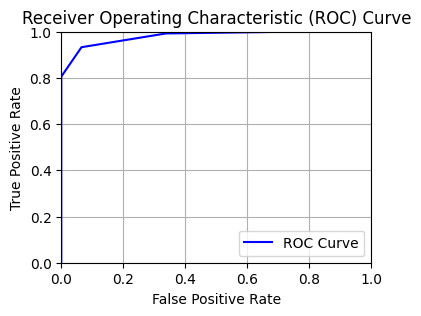

Accuracy: 0.972
AUC: 0.98

==================== 2/12 ====================
mentored data: 200, test data: 50, unlabled data: 4750
balanced data: 50, fpositive: 25, fnegative: 25
mentored data: 150
Number of subclusters: 5
Initial Demo data to agent: 50
############### Mentoring and Demonstrating 150 examples to Agent by Human Expert ###############


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:04<00:00, 31.32it/s]


############### Mentoring and Demonstrating 150 examples to Agent by Human Expert DONE!!! ###############
Reward_list: [0.953, 0.953]
 ############### Labeling 4750 unlabeled data with the help of Agent ###############


100%|██████████████████████████████████████████████████████████████████████████████| 4750/4750 [00:50<00:00, 93.90it/s]


 ############### Labeling 4750 unlabeled data with the help of Agent DONE!!! ###############
TP: 2314  FP: 114
FN: 65  TN: 2257
Calculating Dunn's index...
dunn_index:  0.115
Calculating Davies Bouldin index...
davies_bouldin_index:  4.024
Calculating Silhouette index...
silhouette_score:  <function silhouette_score at 0x000001B73E68D1F0>


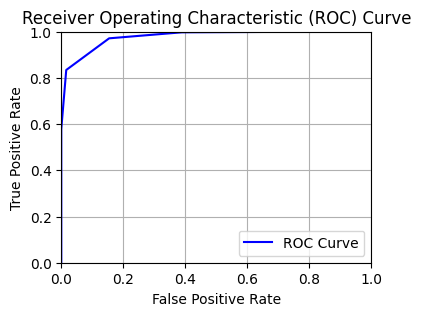

Accuracy: 0.962
AUC: 0.978

==================== 3/12 ====================
mentored data: 200, test data: 50, unlabled data: 4750
balanced data: 50, fpositive: 25, fnegative: 25
mentored data: 150
Number of subclusters: 5
Initial Demo data to agent: 50
############### Mentoring and Demonstrating 150 examples to Agent by Human Expert ###############


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:04<00:00, 32.37it/s]


############### Mentoring and Demonstrating 150 examples to Agent by Human Expert DONE!!! ###############
Reward_list: [0.953, 0.953, 0.987]
 ############### Labeling 4750 unlabeled data with the help of Agent ###############


100%|██████████████████████████████████████████████████████████████████████████████| 4750/4750 [00:51<00:00, 92.91it/s]


 ############### Labeling 4750 unlabeled data with the help of Agent DONE!!! ###############
TP: 2324  FP: 0
FN: 53  TN: 2373
Calculating Dunn's index...
dunn_index:  0.071
Calculating Davies Bouldin index...
davies_bouldin_index:  3.983
Calculating Silhouette index...
silhouette_score:  <function silhouette_score at 0x000001B73E68D1F0>


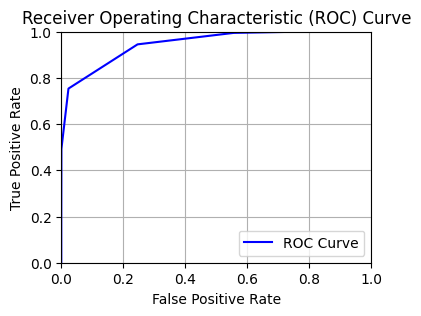

Accuracy: 0.989
AUC: 0.948


*************** Training with 400 size of labled data ***************

==================== 4/12 ====================
mentored data: 400, test data: 100, unlabled data: 4500
balanced data: 50, fpositive: 25, fnegative: 25
mentored data: 350
Number of subclusters: 5
Initial Demo data to agent: 50
############### Mentoring and Demonstrating 350 examples to Agent by Human Expert ###############


100%|████████████████████████████████████████████████████████████████████████████████| 350/350 [00:31<00:00, 11.29it/s]


############### Mentoring and Demonstrating 350 examples to Agent by Human Expert DONE!!! ###############
Reward_list: [0.991]
 ############### Labeling 4500 unlabeled data with the help of Agent ###############


100%|██████████████████████████████████████████████████████████████████████████████| 4500/4500 [00:53<00:00, 83.99it/s]


 ############### Labeling 4500 unlabeled data with the help of Agent DONE!!! ###############
TP: 2225  FP: 0
FN: 38  TN: 2237
Calculating Dunn's index...
dunn_index:  0.101
Calculating Davies Bouldin index...
davies_bouldin_index:  3.984
Calculating Silhouette index...
silhouette_score:  <function silhouette_score at 0x000001B73E68D1F0>


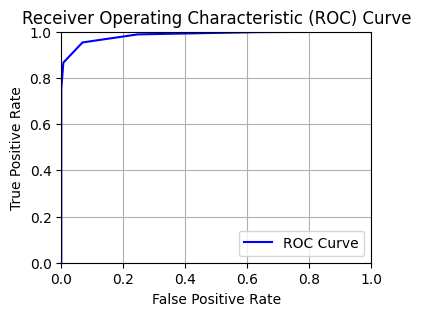

Accuracy: 0.992
AUC: 0.985

==================== 5/12 ====================
mentored data: 400, test data: 100, unlabled data: 4500
balanced data: 50, fpositive: 25, fnegative: 25
mentored data: 350
Number of subclusters: 5
Initial Demo data to agent: 50
############### Mentoring and Demonstrating 350 examples to Agent by Human Expert ###############


100%|████████████████████████████████████████████████████████████████████████████████| 350/350 [00:30<00:00, 11.56it/s]


############### Mentoring and Demonstrating 350 examples to Agent by Human Expert DONE!!! ###############
Reward_list: [0.991, 0.974]
 ############### Labeling 4500 unlabeled data with the help of Agent ###############


100%|██████████████████████████████████████████████████████████████████████████████| 4500/4500 [00:54<00:00, 83.00it/s]


 ############### Labeling 4500 unlabeled data with the help of Agent DONE!!! ###############
TP: 2179  FP: 0
FN: 67  TN: 2254
Calculating Dunn's index...
dunn_index:  0.105
Calculating Davies Bouldin index...
davies_bouldin_index:  3.987
Calculating Silhouette index...
silhouette_score:  <function silhouette_score at 0x000001B73E68D1F0>


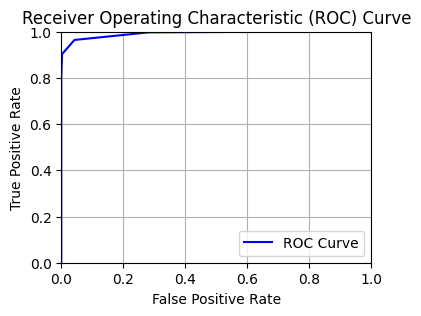

Accuracy: 0.985
AUC: 0.992

==================== 6/12 ====================
mentored data: 400, test data: 100, unlabled data: 4500
balanced data: 50, fpositive: 25, fnegative: 25
mentored data: 350
Number of subclusters: 5
Initial Demo data to agent: 50
############### Mentoring and Demonstrating 350 examples to Agent by Human Expert ###############


100%|████████████████████████████████████████████████████████████████████████████████| 350/350 [00:29<00:00, 11.89it/s]


############### Mentoring and Demonstrating 350 examples to Agent by Human Expert DONE!!! ###############
Reward_list: [0.991, 0.974, 0.943]
 ############### Labeling 4500 unlabeled data with the help of Agent ###############


100%|██████████████████████████████████████████████████████████████████████████████| 4500/4500 [00:51<00:00, 88.00it/s]


 ############### Labeling 4500 unlabeled data with the help of Agent DONE!!! ###############
TP: 2179  FP: 183
FN: 85  TN: 2053
Calculating Dunn's index...
dunn_index:  0.094
Calculating Davies Bouldin index...
davies_bouldin_index:  4.018
Calculating Silhouette index...
silhouette_score:  <function silhouette_score at 0x000001B73E68D1F0>


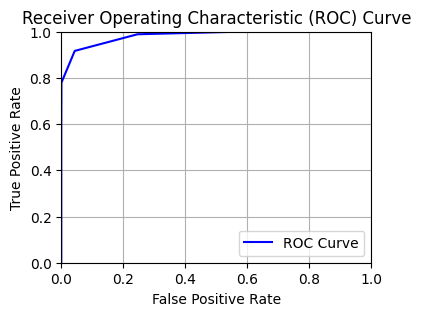

Accuracy: 0.94
AUC: 0.982


*************** Training with 800 size of labled data ***************

==================== 7/12 ====================
mentored data: 800, test data: 200, unlabled data: 4000
balanced data: 50, fpositive: 25, fnegative: 25
mentored data: 750
Number of subclusters: 5
Initial Demo data to agent: 50
############### Mentoring and Demonstrating 750 examples to Agent by Human Expert ###############


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [02:37<00:00,  4.75it/s]


############### Mentoring and Demonstrating 750 examples to Agent by Human Expert DONE!!! ###############
Reward_list: [0.995]
 ############### Labeling 4000 unlabeled data with the help of Agent ###############


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:52<00:00, 75.65it/s]


 ############### Labeling 4000 unlabeled data with the help of Agent DONE!!! ###############
TP: 1977  FP: 0
FN: 40  TN: 1983
Calculating Dunn's index...
dunn_index:  0.093
Calculating Davies Bouldin index...
davies_bouldin_index:  3.98
Calculating Silhouette index...
silhouette_score:  <function silhouette_score at 0x000001B73E68D1F0>


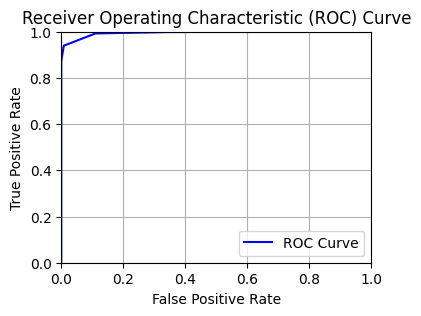

Accuracy: 0.99
AUC: 0.995

==================== 8/12 ====================
mentored data: 800, test data: 200, unlabled data: 4000
balanced data: 50, fpositive: 25, fnegative: 25
mentored data: 750
Number of subclusters: 5
Initial Demo data to agent: 50
############### Mentoring and Demonstrating 750 examples to Agent by Human Expert ###############


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [02:40<00:00,  4.66it/s]


############### Mentoring and Demonstrating 750 examples to Agent by Human Expert DONE!!! ###############
Reward_list: [0.995, 0.996]
 ############### Labeling 4000 unlabeled data with the help of Agent ###############


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:53<00:00, 75.19it/s]


 ############### Labeling 4000 unlabeled data with the help of Agent DONE!!! ###############
TP: 1980  FP: 0
FN: 22  TN: 1998
Calculating Dunn's index...
dunn_index:  0.145
Calculating Davies Bouldin index...
davies_bouldin_index:  3.986
Calculating Silhouette index...
silhouette_score:  <function silhouette_score at 0x000001B73E68D1F0>


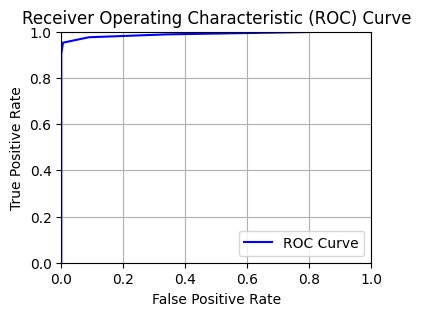

Accuracy: 0.995
AUC: 0.989

==================== 9/12 ====================
mentored data: 800, test data: 200, unlabled data: 4000
balanced data: 50, fpositive: 25, fnegative: 25
mentored data: 750
Number of subclusters: 5
Initial Demo data to agent: 50
############### Mentoring and Demonstrating 750 examples to Agent by Human Expert ###############


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [02:34<00:00,  4.85it/s]


############### Mentoring and Demonstrating 750 examples to Agent by Human Expert DONE!!! ###############
Reward_list: [0.995, 0.996, 0.973]
 ############### Labeling 4000 unlabeled data with the help of Agent ###############


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:51<00:00, 77.72it/s]


 ############### Labeling 4000 unlabeled data with the help of Agent DONE!!! ###############
TP: 1945  FP: 0
FN: 77  TN: 1978
Calculating Dunn's index...
dunn_index:  0.071
Calculating Davies Bouldin index...
davies_bouldin_index:  3.987
Calculating Silhouette index...
silhouette_score:  <function silhouette_score at 0x000001B73E68D1F0>


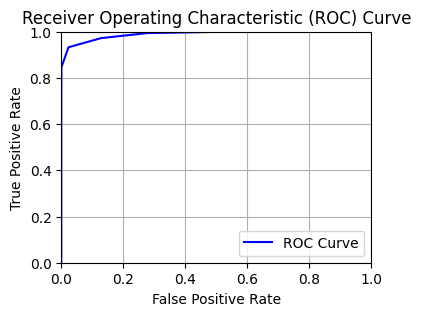

Accuracy: 0.981
AUC: 0.989


*************** Training with 1600 size of labled data ***************

==================== 10/12 ====================
mentored data: 1600, test data: 400, unlabled data: 3000
balanced data: 50, fpositive: 25, fnegative: 25
mentored data: 1550
Number of subclusters: 5
Initial Demo data to agent: 50
############### Mentoring and Demonstrating 1550 examples to Agent by Human Expert ###############


100%|██████████████████████████████████████████████████████████████████████████████| 1550/1550 [12:01<00:00,  2.15it/s]


############### Mentoring and Demonstrating 1550 examples to Agent by Human Expert DONE!!! ###############
Reward_list: [0.975]
 ############### Labeling 3000 unlabeled data with the help of Agent ###############


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:48<00:00, 62.19it/s]


 ############### Labeling 3000 unlabeled data with the help of Agent DONE!!! ###############
TP: 1441  FP: 0
FN: 56  TN: 1503
Calculating Dunn's index...
dunn_index:  0.092
Calculating Davies Bouldin index...
davies_bouldin_index:  3.974
Calculating Silhouette index...
silhouette_score:  <function silhouette_score at 0x000001B73E68D1F0>


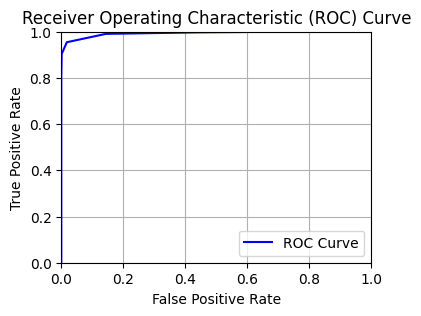

Accuracy: 0.981
AUC: 0.993

==================== 11/12 ====================
mentored data: 1600, test data: 400, unlabled data: 3000
balanced data: 50, fpositive: 25, fnegative: 25
mentored data: 1550
Number of subclusters: 5
Initial Demo data to agent: 50
############### Mentoring and Demonstrating 1550 examples to Agent by Human Expert ###############


100%|██████████████████████████████████████████████████████████████████████████████| 1550/1550 [12:28<00:00,  2.07it/s]


############### Mentoring and Demonstrating 1550 examples to Agent by Human Expert DONE!!! ###############
Reward_list: [0.975, 0.995]
 ############### Labeling 3000 unlabeled data with the help of Agent ###############


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:44<00:00, 67.92it/s]


 ############### Labeling 3000 unlabeled data with the help of Agent DONE!!! ###############
TP: 1483  FP: 0
FN: 13  TN: 1504
Calculating Dunn's index...
dunn_index:  0.234
Calculating Davies Bouldin index...
davies_bouldin_index:  3.981
Calculating Silhouette index...
silhouette_score:  <function silhouette_score at 0x000001B73E68D1F0>


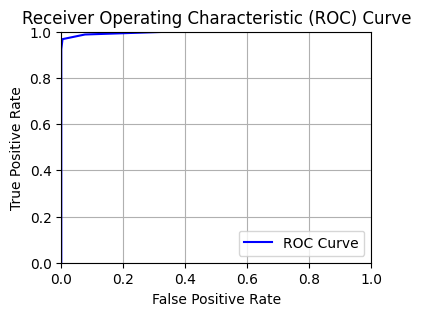

Accuracy: 0.996
AUC: 0.996

==================== 12/12 ====================
mentored data: 1600, test data: 400, unlabled data: 3000
balanced data: 50, fpositive: 25, fnegative: 25
mentored data: 1550
Number of subclusters: 5
Initial Demo data to agent: 50
############### Mentoring and Demonstrating 1550 examples to Agent by Human Expert ###############


100%|██████████████████████████████████████████████████████████████████████████████| 1550/1550 [12:59<00:00,  1.99it/s]


############### Mentoring and Demonstrating 1550 examples to Agent by Human Expert DONE!!! ###############
Reward_list: [0.975, 0.995, 0.995]
 ############### Labeling 3000 unlabeled data with the help of Agent ###############


 20%|████████████████                                                               | 610/3000 [00:07<00:33, 71.46it/s]

TP: 287  FP: 0
FN: 2  TN: 311


 40%|███████████████████████████████▍                                              | 1207/3000 [00:16<00:28, 62.48it/s]

TP: 592  FP: 0
FN: 6  TN: 602


 60%|███████████████████████████████████████████████                               | 1810/3000 [00:26<00:21, 55.92it/s]

TP: 897  FP: 0
FN: 12  TN: 891


 80%|██████████████████████████████████████████████████████████████▌               | 2408/3000 [00:36<00:12, 48.79it/s]

TP: 1197  FP: 0
FN: 17  TN: 1186


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:48<00:00, 62.42it/s]


TP: 1494  FP: 0
FN: 21  TN: 1485
 ############### Labeling 3000 unlabeled data with the help of Agent DONE!!! ###############
TP: 1494  FP: 0
FN: 21  TN: 1485
Calculating Dunn's index...
dunn_index:  0.121
Calculating Davies Bouldin index...
davies_bouldin_index:  3.983
Calculating Silhouette index...
silhouette_score:  <function silhouette_score at 0x000001B73E68D1F0>


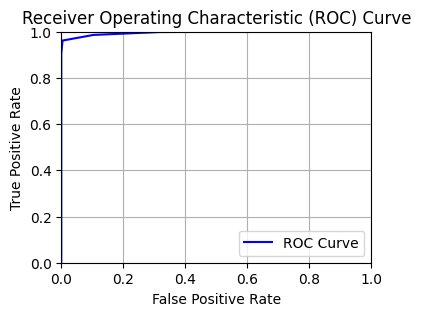

Accuracy: 0.993
AUC: 0.995
Agent Test Acc [0.98, 0.99, 0.9866666666666667, 0.985, 0.988, 0.9866666666666667, 0.9885714285714285, 0.99]
Independent Acc [0.997, 0.995, 0.993, 0.993, 0.993]


In [23]:
CURRENT_TIME =  str(round(datetime.datetime.now().timestamp()))
os.mkdir(f"./test_{s_model}_{s_distance}_{CURRENT_TIME}")
n_neighbours = int(15 * DATASET_SIZE)
INITAL_SAMPLE_SIZE = int(50 * DATASET_SIZE)
mentored_size = [200, 400, 800, 1600] # 80 percent
test_data_size = [50, 100, 200, 400] # 20 percent

mentored_size = [int(size * DATASET_SIZE) for size in mentored_size]
test_data_size = [int(size * DATASET_SIZE) for size in test_data_size]

data_frame_metrix = {
  "Mentored Data": [],
  "Dataset": [],
  "Mentored Covid-ve": [],
  "Mentored Covid+ve": [],
  "Unlabeled Data": [],
  "Accuracy": [],
  "Specificity": [],
  "Sensitivity": [],
  "AUC": [],
  "Dunn Index": [],
  "Davies Bouldin Index": [],
  "Silhouette Score": [],
  "TP": [],
  "TN": [],
  "FP": [],
  "FN": [],
  "Human Corrected Count": [],
  "Agent Corrected Count": []
}

data_frame_agent = {
  "Accuracy": [],
  "Precision": [],
  "Recall": [],
  "F1 Score": [],
  "Confusion Matrix": [],
  "Agent Reward": []
}

global_count = 0

for ds_index, size in enumerate(mentored_size):
  agent = Agent()
  print("\n\n{} Training with {} size of labled data {}".format('*'*15, size, '*'*15))

  test_data_set = ft_dataset[:test_data_size[ds_index]] # get test data set from total data set pool
  remaining_data_set = ft_dataset[test_data_size[ds_index]:] # rest data from total data pool is used for training

  mentored_data_sets, unlabeled_data_sets = data_loader(remaining_data_set, size)

  # mentored_data_sets ==> three sets: [d1, d2, d3] ==> eg: [0-40, 320-360, 640-680] three epoc
  for epoch, mentored_data in enumerate(mentored_data_sets):
    global_count += 1
    print(f"\n{'='*20} {global_count}/{len(mentored_size) * len(mentored_data_sets)} {'='*20}")
    data_frame_mistake = {
      "Image name": [],
      "Mistake index": [],
      "Mistake ID": [],
      "Original label": [],
      "Predicted label": []
    }

    neg_img, pos_img = 0, 0

    # collect the ground truth (label) of all the predicting images =>> key: 0 & 1 (class), value: tuple (data['id'], data['label']), required to calulate TP, FP, FN, TN
    label_gt = {0: [], 1: []}
    # collect the ground truth (id) of all the predicting images =>> key: 0 & 1 (class), value: ground truth id
    id_gt = {0: [], 1: []}

    # collect the predicted label for all the images =>> key: 0 & 1 (class), value: tuple(query['id'], decision_list.count(1)/n_neighbours)
    # Percentage of predicted positive class, required to calculate AUC/ROC value
    label_pred = {0: [], 1: []}
    # collect the predicted id for all the images =>> key: 0 & 1 (class), value: predicted ids, required to calulate TP, FP, FN, TN
    id_pred = {0: [],  1: []}

    # feature label =>> key: 0 & 1 (class), value: deep feature of image
    cluster_centers_dict = {0: [], 1: []}

    unlabeled_data = unlabeled_data_sets[epoch]

    print(f"mentored data: {len(mentored_data)}, test data: {len(test_data_set)}, unlabled data: {len(unlabeled_data)}")

    neg_mentored_img, pos_mentored_img = 0, 0
    for data in mentored_data:
      if data['label'] == 0:
          neg_mentored_img += 1
      else:
          pos_mentored_img += 1

    # defining Human Expert
    human_expert = HumanExpert(mentored_data)

    # select balanced mentored data (50% from positive and 50% from negative)
    fnegative = data_separation(mentored_data, 0, int(INITAL_SAMPLE_SIZE/2))  # Get the 'INITAL_SAMPLE_SIZE/2' negative features from 'mentored_data'
    fpositive = data_separation(mentored_data, 1, int(INITAL_SAMPLE_SIZE/2))  # Get the 'INITAL_SAMPLE_SIZE/2' positive features from 'mentored_data'

    print(f"balanced data: {INITAL_SAMPLE_SIZE}, fpositive: {len(fpositive)}, fnegative: {len(fnegative)}")
    print(f"mentored data: {len(mentored_data)}")

    n_subclusters = math.ceil(5 * DATASET_SIZE) if DATASET_SIZE > 0.5 else 2
    print("Number of subclusters: {}".format(n_subclusters))

    # fit the feature data to the model
    model_cluster = fit_to_clusters(fnegative + fpositive, 2)

    cc_neg_features, c_neg_features = sub_clusters(fnegative, n_subclusters)  # Get the cluster center and negative clusters (Using K-means algorithm)
    cc_pos_features, c_pos_features = sub_clusters(fpositive, n_subclusters)  # Get the cluster center and positive clusters (Using K-means algorithm)

    # initial model
    model_cluster.update(cc_neg_features, cc_pos_features, c_neg_features, c_pos_features)

    n_obs, human_corrected_count, mistake_index, agent_action_count = 0, 0, INITAL_SAMPLE_SIZE, 0

    # demonstrate to the RL Agent from labeled data by human
    fdemo_data = [(init_fn, 0) for init_fn in fnegative]
    pdemo_data = [(init_fp, 1) for init_fp in fpositive]
    demo_data = fdemo_data + pdemo_data

    shuffle(demo_data)

    print(f"Initial Demo data to agent: {len(demo_data)}")

    # initialize dagger data by initial demo data
    dagger_data = copy.deepcopy(demo_data)

    # demonstrate agent by initial demo data
    agent.imitate_human(dagger_data)

    print(f"{'#' * 15} Mentoring and Demonstrating {len(mentored_data)} examples to Agent by Human Expert {'#' * 15}")

    agent.reset_reward()

    # loop is for the mentored data as well as imitation learning --> Notice mentored_data=True in argument of the function call distance.
    for state in tqdm(mentored_data):
      n_obs += 1
      cluster_centers_dict = {0: cc_neg_features, 1: cc_pos_features}

      (data_frame_mistake,
       human_corrected_count,
       _,
       label_pred,
       c_neg_features,
       c_pos_features) = distance(state,
                                 cluster_centers_dict,
                                 distance_type,
                                 id_pred, # not being used in this case
                                 label_pred,
                                 c_neg_features,
                                 c_pos_features,
                                 n_neighbours,
                                 human_corrected_count,
                                 mistake_index,
                                 data_frame_mistake,
                                 human_expert,
                                 agent=None,
                                 mentored_data=True)

      cc_neg_features, cc_pos_features = get_updated_cc(c_neg_features, c_pos_features)  # Get the mean of the features
      mistake_index += 1

      # Updating the kmeans model (including labels and clusters) every 10 data [this update is optional]
      if n_obs%10 == 0 or n_obs == len(mentored_data):
        model_cluster.update(cc_neg_features, cc_pos_features, c_neg_features, c_pos_features)

      # dagger step

      # query to human for actions
      state_id = state['id']
      state_obs = state['image']
      expert_actions = human_expert.policy(state_id) # ground truth from human expert

      # actions from agent itself
      agent_actions = agent.policy(state_obs.reshape(1, -1)) # changing (n, ) to (1, n) and send to agent model
      agent.update_reward(agent_actions[0], expert_actions[0], n_obs)

      # if agent start to perform bad, use expert's label in new dataset to train the agent.
      if agent.avg_reward < 0.95: # (max reward is 1, worst is 0)
        actions = expert_actions # actions from human expert
      else:
        actions = agent_actions # action from agent

      # aggregate the data
      dagger_data.append((state_obs, actions[0]))

      # train model with aggregated data
      agent.imitate_human(dagger_data)


    print(f"{'#' * 15} Mentoring and Demonstrating {len(mentored_data)} examples to Agent by Human Expert DONE!!! {'#' * 15}")

    agent.update_reward_list()
    print("Reward_list:", agent.reward_list)

    data_f_mistake = pd.DataFrame.from_dict(data_frame_mistake)
    data_f_mistake.to_csv(f"./test_{s_model}_{s_distance}_{CURRENT_TIME}/mistake_{size}_d{epoch + 1}.csv", index=False)

    test_obs = []
    gt_actions = []
    agent_acc_list = []
    test_count = 0
    for data in test_data_set:
      test_count += 1
      test_obs.append(data['image'])
      gt_actions.append(data['label'])

      if global_count == 12 and test_count % (int(len(test_data_set) / 5)) == 0:
        # for each step's accuracy
        each_preds = agent.policy(np.array(test_obs))
        each_acc = accuracy_score(gt_actions, each_preds)
        agent_acc_list.append(each_acc)

    # predict on test observations
    test_preds = agent.policy(np.array(test_obs))

    agent_accuracy = accuracy_score(gt_actions, test_preds)
    agent_precision = precision_score(gt_actions, test_preds, average='weighted')
    agent_recall = recall_score(gt_actions, test_preds, average='weighted')
    agent_f1 = f1_score(gt_actions, test_preds, average='weighted')
    agent_conf_matrix = confusion_matrix(gt_actions, test_preds)

    data_frame_agent["Accuracy"].append(round(agent_accuracy, 3))
    data_frame_agent["Precision"].append(round(agent_precision, 3))
    data_frame_agent["Recall"].append(round(agent_recall, 3))
    data_frame_agent["F1 Score"].append(round(agent_f1, 3))
    data_frame_agent["Confusion Matrix"].append(agent_conf_matrix)
    data_frame_agent["Agent Reward"].append(agent.avg_reward)


    data_f_agent = pd.DataFrame.from_dict(data_frame_agent)
    data_f_agent.to_csv(f"./test_{s_model}_{s_distance}_{CURRENT_TIME}/agent_evaluation.csv", index=False)

    agent_corrected_count = 0
    print(f" {'#' * 15} Labeling {len(unlabeled_data)} unlabeled data with the help of Agent {'#' * 15}")
    # loop is for the unlabled data --> Notice mentored_data=False in argument of the function call distance.
    unlab_acc_list = []
    ulabel_count = 0
    for new_data in tqdm(unlabeled_data):
      ulabel_count = ulabel_count + 1
      if new_data["label"] == 1:
        id_gt[1].append(new_data['id'])
        label_gt[1].append((new_data['id'], new_data['label'])) # Required to calulate TP, FP, FN, TN
      else:
        id_gt[0].append(new_data['id'])
        label_gt[0].append((new_data['id'], new_data['label']))

      cluster_centers_dict = {0: cc_neg_features, 1: cc_pos_features}

      (_,
       agent_corrected_count,
       id_pred,
       label_pred,
       c_neg_features,
       c_pos_features) = distance(new_data,
                                 cluster_centers_dict,
                                 distance_type,
                                 id_pred,
                                 label_pred,
                                 c_neg_features,
                                 c_pos_features,
                                 n_neighbours,
                                 agent_corrected_count,
                                 mistake_index,
                                 data_frame_mistake,
                                 human_expert,
                                 agent=agent,
                                 mentored_data=False)

      cc_neg_features, cc_pos_features = get_updated_cc(c_neg_features, c_pos_features)   # Get the mean of the features
      if global_count == 12 and ulabel_count % (int(len(unlabeled_data) / 5)) == 0:
        acc, spe, sen, tp, tn, fp, fn = classification_metrices(id_gt, id_pred)
        unlab_acc_list.append(acc)

    print(f" {'#' * 15} Labeling {len(unlabeled_data)} unlabeled data with the help of Agent DONE!!! {'#' * 15}")

    accuracy, specificity, sensitivity, TP, TN, FP, FN = classification_metrices(id_gt, id_pred)

    # Flattened as required to calculate clustering indices
    flattened_neg_features = flatten_features(c_neg_features)
    flattened_pos_features = flatten_features(c_pos_features)

    dunn_index, davies_bouldin_index, silhouette__score = cluster_metrices(flattened_neg_features, flattened_pos_features)
    cl_auc, fpr, tpr = roc_auc_curve(label_gt, label_pred)
    draw_auc(fpr, tpr)

    data_frame_metrix["Dataset"].append(f"M_{ds_index + 1}_D_{epoch + 1}")
    data_frame_metrix["Mentored Data"].append(size)
    data_frame_metrix["Mentored Covid+ve"].append(neg_mentored_img)
    data_frame_metrix["Mentored Covid-ve"].append(pos_mentored_img)
    data_frame_metrix["Unlabeled Data"].append(len(unlabeled_data))
    data_frame_metrix["Accuracy"].append(accuracy)
    data_frame_metrix["Specificity"].append(specificity)
    data_frame_metrix["Sensitivity"].append(sensitivity)
    data_frame_metrix["AUC"].append(cl_auc)
    data_frame_metrix["Dunn Index"].append(dunn_index)
    data_frame_metrix["Davies Bouldin Index"].append(davies_bouldin_index)
    data_frame_metrix["Silhouette Score"].append(silhouette__score)
    data_frame_metrix["TP"].append(TP)
    data_frame_metrix["TN"].append(TN)
    data_frame_metrix["FP"].append(FP)
    data_frame_metrix["FN"].append(FN)
    data_frame_metrix["Human Corrected Count"].append(human_corrected_count)
    data_frame_metrix["Agent Corrected Count"].append(agent_corrected_count)

    print(f"Accuracy: {accuracy}")
    print(f"AUC: {cl_auc}")
    data_f_matrix = pd.DataFrame.from_dict(data_frame_metrix)
    data_f_matrix.to_csv(f"./test_{s_model}_{s_distance}_{CURRENT_TIME}/cluster_model_evaluation.csv", index=False)

    if global_count == 12:
      print("Agent Test Acc", agent_acc_list)
      print("Independent Acc", unlab_acc_list)

### END